# **TFRECORD CREATION**

## Libraries and initial setup

In [1]:
import os  
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import tensorflow as tf 
import random 
import concurrent.futures

# User-defined parameters
IMG_SIZE = 380  # Size to which the images will be resized (width and height in pixels)
dataset_dir = 'Prova'  # Directory where the dataset is stored
output_dir = 'Output_' + dataset_dir  # Directory where the output will be stored
NUM_SHARDS = 30  # Number of shards (subsets) into which the dataset will be divided
BATCH_SIZE = 100  # Dimensione del batch per l'elaborazione delle immagini
NUM_WORKERS = 4  # Numero di worker per il parallelismo
VISUALIZE_RANDOM_IMAGE = False  # Flag to indicate whether a random image should be visualized
VISUALIZE_TFRECORD_STRUCTURE = False  # Flag to indicate whether the structure of a TFRecord file should be visualized

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)  # Creates the output directory if it doesn't already exist


## Loading the Dataset, Labels, and Creating TFRecords

In [2]:
# Funzione per caricare etichette da file Excel
def load_labels_from_excel(excel_file):
    df = pd.read_excel(excel_file)  # Carica il file Excel in un DataFrame pandas
    return dict(zip(df['Filename'], df['RST']))  # Converte le colonne 'Filename' e 'RST' in un dizionario

# Funzione per caricare percorsi delle immagini e etichette da directory e dizionario
def load_image_paths_and_labels(directory, labels_dict):
    image_paths = []  # Inizializza una lista vuota per i percorsi delle immagini
    image_labels = []  # Inizializza una lista vuota per le etichette corrispondenti
    for root, _, files in os.walk(directory):  # Cammina attraverso la directory specificata e le sue sottodirectory
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Filtra solo i file di immagine con estensioni specifiche
                image_paths.append(os.path.join(root, file))  # Aggiunge il percorso completo dell'immagine alla lista
                image_labels.append(labels_dict.get(file, -1))  # Aggiunge l'etichetta corrispondente o -1 se non trovata
    return image_paths, image_labels  # Restituisce le liste dei percorsi delle immagini e delle etichette

# Funzione per preprocessare immagini
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)  # Legge l'immagine dal percorso specificato
    if tf.strings.regex_full_match(image_path, ".*\\.jpg") or tf.strings.regex_full_match(image_path, ".*\\.jpeg"):
        image = tf.image.decode_jpeg(image, channels=3)  # Decodifica l'immagine JPEG
    else:
        image = tf.image.decode_png(image, channels=3)  # Decodifica l'immagine PNG
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Ridimensiona l'immagine alla dimensione specificata
    return image  # Restituisce l'immagine preprocessata

# Funzione per preprocessare e serializzare un'immagine e un'etichetta
def preprocess_and_serialize(idx, image_paths, image_labels):
    image = load_and_preprocess_image(image_paths[idx])  # Carica e preprocessa l'immagine con l'indice specificato
    image = tf.cast(image, tf.uint8)  # Converte l'immagine in tipo uint8
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),  # Codifica l'immagine come JPEG in formato bytes
        'label': tf.train.Feature(float_list=tf.train.FloatList(value=[image_labels[idx]])),  # Associa l'etichetta corrispondente
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))  # Crea un esempio TFRecord con l'immagine e l'etichetta
    return example.SerializeToString()  # Serializza l'esempio in una stringa

# Funzione per creare TFRecord in batch con parallelismo
def create_tfrecord_in_batches(image_paths, image_labels, output_file, batch_size=BATCH_SIZE, num_shards=NUM_SHARDS, num_workers=NUM_WORKERS):
    num_samples = len(image_paths)  # Conta il numero totale di immagini
    indices = np.arange(num_samples)  # Crea una lista di indici da 0 a num_samples-1
    np.random.shuffle(indices)  # Mescola gli indici per randomizzare l'ordine delle immagini

    shard_size = num_samples // num_shards  # Calcola la dimensione di ogni shard
    for shard_id in range(num_shards):
        shard_filename = f"{output_file}_{shard_id+1}-of-{num_shards}.tfrecord"  # Genera il nome del file TFRecord per lo shard corrente
        with tf.io.TFRecordWriter(shard_filename) as writer:  # Apre un writer TFRecord per scrivere nel file
            start_index = shard_id * shard_size  # Calcola l'indice di inizio per questo shard
            end_index = (shard_id + 1) * shard_size if shard_id != num_shards - 1 else num_samples  # Calcola l'indice di fine per questo shard
            for i in range(start_index, end_index, batch_size):
                batch_end = min(i + batch_size, end_index)  # Calcola l'indice di fine per questo batch
                
                # Preprocessa le immagini in parallelo utilizzando ThreadPoolExecutor
                with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = [
                        executor.submit(preprocess_and_serialize, indices[j], image_paths, image_labels)
                        for j in range(i, batch_end)
                    ]
                    
                    for future in concurrent.futures.as_completed(futures):  # Scrive ogni immagine preprocessata nel file TFRecord
                        writer.write(future.result())

# Carica etichette
train_labels_dict = load_labels_from_excel(os.path.join(dataset_dir, 'train.xlsx'))  # Carica le etichette di training da un file Excel
val_labels_dict = load_labels_from_excel(os.path.join(dataset_dir, 'validation.xlsx'))  # Carica le etichette di validazione da un file Excel
test_labels_dict = load_labels_from_excel(os.path.join(dataset_dir, 'test.xlsx'))  # Carica le etichette di test da un file Excel

# Carica percorsi delle immagini e etichette
train_image_paths, train_image_labels = load_image_paths_and_labels(os.path.join(dataset_dir, 'train'), train_labels_dict)  # Carica percorsi delle immagini e etichette di training
val_image_paths, val_image_labels = load_image_paths_and_labels(os.path.join(dataset_dir, 'validation'), val_labels_dict)  # Carica percorsi delle immagini e etichette di validazione
test_image_paths, test_image_labels = load_image_paths_and_labels(os.path.join(dataset_dir, 'test'), test_labels_dict)  # Carica percorsi delle immagini e etichette di test

# Creazione dei TFRecord in batch
create_tfrecord_in_batches(train_image_paths, train_image_labels, os.path.join(dataset_dir, 'train'))  # Crea i file TFRecord per il training set
create_tfrecord_in_batches(val_image_paths, val_image_labels, os.path.join(dataset_dir, 'val'))  # Crea i file TFRecord per il validation set
create_tfrecord_in_batches(test_image_paths, test_image_labels, os.path.join(dataset_dir, 'test'))  # Crea i file TFRecord per il test set

# Stampa numero di immagini in ciascun dataset
print('Ci sono', len(train_image_paths), 'immagini nel dataset di training')  # Stampa il numero di immagini nel training set
print('Ci sono', len(val_image_paths), 'immagini nel dataset di validation')  # Stampa il numero di immagini nel validation set
print('Ci sono', len(test_image_paths), 'immagini nel dataset di testing')  # Stampa il numero di immagini nel test set


Ci sono 1050 immagini nel dataset di training
Ci sono 301 immagini nel dataset di validation
Ci sono 154 immagini nel dataset di testing


1. Caricamento delle Etichette da File Excel:
- Richiesta della CPU: La CPU chiede al sistema I/O di aprire il file Excel specificato (excel_file) dal disco.
- Lettura del File: Il sistema I/O legge il file Excel e lo carica in RAM come un DataFrame df utilizzando la libreria pandas.
- Estrazione delle Informazioni: La CPU accede al DataFrame df in RAM, estrae le colonne Filename e RST, e le combina in un dizionario (labels_dict) tramite la funzione zip.
- Memorizzazione in RAM: La CPU memorizza il dizionario risultante (labels_dict), contenente le etichette, in RAM per un accesso rapido durante le operazioni successive.

2. Caricamento dei Percorsi delle Immagini:
- Esplorazione della Directory: La CPU chiede al sistema I/O di esplorare la directory specificata (directory) e le sue sottodirectory per identificare tutti i file di immagini con estensioni .png, .jpg, o .jpeg.
- Lettura dei File: Il sistema I/O legge i nomi dei file dalle directory sul disco e li fornisce alla CPU.
- Costruzione delle Liste: La CPU costruisce una lista dei percorsi completi delle immagini (image_paths), memorizzandola in RAM. Contemporaneamente, verifica l'esistenza di ogni immagine nel dizionario delle etichette (labels_dict) e associa a ciascuna immagine la sua etichetta corrispondente o un valore predefinito (-1) se non presente nel dizionario.
- Output della Funzione: Le liste dei percorsi delle immagini (image_paths) e delle etichette (image_labels) vengono memorizzate in RAM e restituite come output della funzione.

3. Creazione della Lista di Indici e Randomizzazione:
- Generazione degli Indici: La CPU genera una lista di indici in RAM a partire dai percorsi delle immagini (image_paths) e la randomizza per garantire un ordine casuale delle immagini durante la creazione dei TFRecord.
- Calcolo della Dimensione dello Shard: La CPU calcola la dimensione di ogni shard in base al numero totale di immagini e al numero di shard (num_shards).
- Creazione del File TFRecord Vuoto: Il sistema I/O crea il file TFRecord vuoto per il primo shard sul disco, pronto per essere popolato con i dati delle immagini.

4. Caricamento delle Immagini e Preprocessing in Parallelo:
- Selezione dei Percorsi per il Batch: La CPU seleziona un insieme di percorsi di immagini pari al batch size (ad esempio, 100 percorsi) dalla lista completa di image_paths memorizzata in RAM. Questi percorsi vengono quindi passati ai thread per il caricamento e il preprocessing.
- Avvio del Parallelismo: Il ThreadPoolExecutor avvia un numero definito di thread (es. num_workers=4).
- Caricamento delle Immagini: Ogni thread carica una delle immagini dal disco alla RAM utilizzando i percorsi forniti. Questo processo avviene in parallelo, con più immagini caricate simultaneamente. Il numero di immagini caricate contemporaneamente è limitato dal numero di thread attivi.
- Preprocessing delle Immagini: Subito dopo il caricamento, ogni thread esegue il preprocessing dell'immagine in RAM, che include operazioni come la decodifica del formato e il ridimensionamento.
- Codifica delle Immagini: Dopo il preprocessing, l'immagine viene codificata in una stringa di byte (es. utilizzando tf.io.encode_jpeg).

5. Passaggio al Thread Principale e Scrittura nel TFRecord:
- Restituzione dei Risultati: Una volta terminato il preprocessing e la codifica, i thread restituiscono il risultato al thread principale o al gestore delle scritture.
- Scrittura Sequenziale: Il thread principale gestisce la scrittura nel file TFRecord. Anche se il preprocessing è avvenuto in parallelo, la scrittura nel file avviene in modo sequenziale per garantire l'integrità dei dati.
- Liberazione della Memoria: Dopo che l'immagine codificata è stata scritta nel file TFRecord, la memoria utilizzata viene liberata, permettendo ai thread di continuare con il prossimo gruppo di immagini.

6. Ripetizione del Processo per Tutti i Batch:
- Ciclo Continuo: Il processo di caricamento, preprocessing, codifica e scrittura continua fino a quando tutte le immagini nel batch corrente sono state elaborate e scritte nel file TFRecord.
- Nuovo Batch: Se ci sono ancora immagini nel dataset da processare, il processo riprende con un nuovo batch, ripetendo le fasi sopra descritte. Questo processo si ripete più volte per riempire uno shard.
- Nuovo Shard: Una volta che tutte le immagini per un determinato shard sono state elaborate e scritte, si passa alla creazione di un nuovo shard. - - - Questo ciclo si ripete fino a quando tutte le immagini del dataset non sono state processate e scritte nei rispettivi file TFRecord, completando così l'intero dataset.

Punti Chiave del Processo:
- Parallelismo: Il caricamento, il preprocessing e la codifica delle immagini avvengono in parallelo, sfruttando più thread per migliorare l'efficienza e ridurre i tempi di elaborazione.
-S equenzialità nella Scrittura: Nonostante il parallelismo durante le fasi iniziali, la scrittura nel file TFRecord è gestita in modo sequenziale per garantire che i dati siano scritti correttamente e senza conflitti.
- Gestione della Memoria: La memoria viene gestita in modo efficiente liberando lo spazio occupato da un'immagine immediatamente dopo la sua scrittura su disco. Questo assicura che la RAM non si sovraccarichi, mantenendo il sistema reattivo anche durante l'elaborazione di grandi quantità di dati.
- Il batch size determina il numero di immagini elaborate in un ciclo. Influenza il flusso di lavoro organizzando il dataset in gruppi gestibili, ma non determina quante immagini sono mantenute in RAM simultaneamente. La gestione della RAM è invece legata al numero di thread (num_workers) che lavorano in parallelo.

##  Displaying a Random Image and Visualizing TFRecord

In [3]:
# Function to display a random image and its label from disk
def display_random_image(image_paths, labels):
    # Seleziona un percorso di immagine casuale e l'etichetta corrispondente
    idx = np.random.randint(len(image_paths))  # La CPU genera un indice casuale basato sulla lunghezza della lista dei percorsi di immagine
    image_path = image_paths[idx]  # La CPU utilizza l'indice per selezionare un percorso di immagine corrispondente
    label = labels[idx]  # La CPU seleziona l'etichetta corrispondente allo stesso indice

    # Carica e preprocessa l'immagine (come nella funzione precedente di preprocessing)
    image = load_and_preprocess_image(image_path)  # La CPU chiede al sistema I/O di leggere l'immagine dal disco e di caricarla in RAM. Poi l'immagine viene preprocessata in RAM

    # Visualizza l'immagine
    print('Image shape:', image.shape)  # La CPU stampa la forma dell'immagine (es. larghezza, altezza, canali)
    plt.figure(figsize=(6, 6))  # La CPU crea una nuova figura in RAM di dimensioni 6x6 pollici per visualizzare l'immagine
    plt.imshow(image.numpy().astype("uint8"))  # La CPU converte l'immagine in un formato visualizzabile (uint8) e la passa a `matplotlib` per la visualizzazione
    plt.title(f"Label: {label}")  # La CPU imposta il titolo della finestra di visualizzazione con l'etichetta dell'immagine
    plt.axis('off')  # La CPU disattiva gli assi per una visualizzazione più pulita
    plt.show()  # La CPU mostra la finestra di visualizzazione. A questo punto, la RAM contiene l'immagine elaborata e la finestra di visualizzazione

# Function to visualize the structure of a randomly selected sharded TFRecord
def visualize_random_tfrecord(tfrecord_pattern):
    # Ottiene una lista di tutti i file TFRecord che corrispondono al pattern specificato
    tfrecord_files = tf.io.gfile.glob(tfrecord_pattern)  # La CPU chiede al sistema I/O di trovare tutti i file TFRecord che corrispondono al pattern specificato sul disco
    # Seleziona casualmente un file TFRecord dalla lista
    random_tfrecord_file = np.random.choice(tfrecord_files)  # La CPU seleziona casualmente un file TFRecord tra quelli trovati
    
    # Stampa il file TFRecord selezionato
    print(f"Selected TFRecord file: {random_tfrecord_file}")  # La CPU stampa il nome del file TFRecord selezionato

    # Crea un dizionario di descrizione delle caratteristiche
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Definisce che la caratteristica 'image' è una stringa (bytes)
        'label': tf.io.FixedLenFeature([], tf.float32),  # Definisce che la caratteristica 'label' è un float
    }

    # Funzione per analizzare ogni esempio
    def _parse_function(example_proto):
        # Analizza l'input tf.train.Example proto usando il dizionario di descrizione delle caratteristiche
        return tf.io.parse_single_example(example_proto, feature_description)  # La CPU analizza ciascun esempio dal file TFRecord utilizzando la descrizione delle caratteristiche

    # Crea un oggetto TFRecordDataset per leggere i dati dal file TFRecord
    raw_dataset = tf.data.TFRecordDataset(random_tfrecord_file)  # La CPU chiede al sistema I/O di leggere il file TFRecord selezionato e di creare un dataset in RAM

    # Analizza il dataset usando la funzione di parsing
    parsed_dataset = raw_dataset.map(_parse_function)  # La CPU mappa la funzione di parsing su ciascun esempio del dataset per estrarre immagini e etichette

    # Itera attraverso il dataset e stampa le caratteristiche
    for example in parsed_dataset.take(20):  # La CPU iterà sui primi 5 esempi (o un altro numero specificato) del dataset
        image = example['image'].numpy()  # La CPU decodifica l'immagine dai bytes e la memorizza in RAM come array numpy
        label = example['label'].numpy()  # La CPU estrae l'etichetta e la memorizza in RAM
        print(f"Label: {label}")  # La CPU stampa l'etichetta
        print(f"Image (bytes): {image[:100]}...")  # La CPU stampa i primi 100 bytes dell'immagine per una rapida verifica

# Visualizzazione condizionale di un'immagine casuale
if VISUALIZE_RANDOM_IMAGE:
    display_random_image(train_image_paths, train_image_labels)  # Se `VISUALIZE_RANDOM_IMAGE` è True, la CPU esegue la funzione per visualizzare un'immagine casuale dal dataset di training

# Visualizzazione condizionale della struttura di TFRecord e delle immagini
if VISUALIZE_TFRECORD_STRUCTURE:
    print("Random Train TFRecord:")
    visualize_random_tfrecord(os.path.join(dataset_dir, 'train_*.tfrecord'))  # Se `VISUALIZE_TFRECORD_STRUCTURE` è True, la CPU esegue la funzione per visualizzare la struttura di un file TFRecord del training set

    print("\nRandom Validation TFRecord:")
    visualize_random_tfrecord(os.path.join(dataset_dir, 'val_*.tfrecord'))  # Visualizza la struttura di un file TFRecord del validation set

    print("\nRandom Test TFRecord:")
    visualize_random_tfrecord(os.path.join(dataset_dir, 'test_*.tfrecord'))  # Visualizza la struttura di un file TFRecord del test set



# **CNN**

## Libraries and initial setup

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input

# User parameters
IMG_SIZE = 380  # Dimensione delle immagini da utilizzare come input per il modello (lunghezza e larghezza in pixel)
dataset_dir = 'Prova'  # Directory del dataset da utilizzare per l'addestramento e la validazione
output_dir = 'Output_' + dataset_dir  # Directory in cui salvare i risultati dell'addestramento (modelli, log, ecc.)
BATCH_SIZE = 16  # Dimensione del batch per l'addestramento e la validazione
EPOCHS = 3  # Numero massimo di epoche per l'addestramento del modello
SAVE_EVERY_N_EPOCHS = 1  # Frequenza di salvataggio del modello durante l'addestramento (ogni N epoche)

# Early stopping parameters
EARLYSTOPPING_PATIENCE = 5  # Numero di epoche senza miglioramento prima di fermare l'addestramento (Early Stopping)

# Learning rate scheduler parameters
LEARNING_RATE = 0.001  # Tasso di apprendimento iniziale per l'ottimizzatore
LR_SCHEDULER_FACTOR = 0.5  # Fattore di riduzione del tasso di apprendimento quando non si osserva un miglioramento
LR_SCHEDULER_PATIENCE = 2  # Numero di epoche senza miglioramento prima di ridurre il tasso di apprendimento

# TFRecord dataset parameters
CYCLE_LENGTH = 8  # Numero di file TFRecord da leggere in parallelo
BLOCK_LENGTH = 1  # Numero di record da leggere in sequenza da ciascun file prima di passare al successivo

# Dropout fraction
DROPOUT_FRACTION = 0.2  # Percentuale di dropout applicata per prevenire l'overfitting

# Number of layers to train
NUM_TRAINABLE_LAYERS = 10  # Numero di livelli superiori della rete EfficientNet da rendere addestrabili

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)  # Crea la directory di output se non esiste già


## Loading the Dataset, Labels

In [4]:
# Funzione per caricare le etichette da file Excel
def load_labels_from_excel(excel_file):
    # Legge il file Excel e lo carica in un DataFrame pandas
    df = pd.read_excel(excel_file)
    # Converte le colonne del DataFrame in un dizionario, dove le chiavi sono i nomi delle immagini e i valori sono le etichette
    return dict(zip(df['Filename'], df['RST']))

# Caricamento delle mappature delle etichette per i set di addestramento, validazione e test
train_labels_dict = load_labels_from_excel(os.path.join(dataset_dir, 'train.xlsx'))  # Carica le etichette del set di addestramento dal file Excel
val_labels_dict = load_labels_from_excel(os.path.join(dataset_dir, 'validation.xlsx'))  # Carica le etichette del set di validazione dal file Excel
test_labels_dict = load_labels_from_excel(os.path.join(dataset_dir, 'test.xlsx'))  # Carica le etichette del set di test dal file Excel

# Funzione per caricare i percorsi delle immagini e le etichette corrispondenti da una directory e da un dizionario
def load_image_paths_and_labels(directory, labels_dict):
    image_paths = []  # Lista per memorizzare i percorsi delle immagini
    image_labels = []  # Lista per memorizzare le etichette corrispondenti
    for root, _, files in os.walk(directory):  # Esplora la directory specificata e le sue sottodirectory
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Verifica se il file è un'immagine (con estensione .png, .jpg, o .jpeg)
                image_paths.append(os.path.join(root, file))  # Aggiunge il percorso completo dell'immagine alla lista
                image_labels.append(labels_dict.get(file, -1))  # Aggiunge l'etichetta corrispondente dalla mappatura, o -1 se non trovata
    return image_paths, image_labels  # Restituisce le liste dei percorsi delle immagini e delle etichette

# Caricamento dei percorsi delle immagini e delle etichette per i set di addestramento, validazione e test
train_image_paths, train_image_labels = load_image_paths_and_labels(os.path.join(dataset_dir, 'train'), train_labels_dict)  # Carica i percorsi e le etichette per il set di addestramento
val_image_paths, val_image_labels = load_image_paths_and_labels(os.path.join(dataset_dir, 'validation'), val_labels_dict)  # Carica i percorsi e le etichette per il set di validazione
test_image_paths, test_image_labels = load_image_paths_and_labels(os.path.join(dataset_dir, 'test'), test_labels_dict)  # Carica i percorsi e le etichette per il set di test

'''
Alla fine di questo processo, la RAM contiene:
-Dizionari delle etichette per i tre set (train, validation, test).
-Liste dei percorsi delle immagini e liste delle etichette corrispondenti per ciascun set.
'''

'\nAlla fine di questo processo, la RAM contiene:\n-Dizionari delle etichette per i tre set (train, validation, test).\n-Liste dei percorsi delle immagini e liste delle etichette corrispondenti per ciascun set.\n'

## Reading TFRecord Files and Preparing Datasets

In [10]:
# Funzione per fare il parsing di un TFRecord
def parse_tfrecord(tfrecord):
    # Definisce un dizionario di descrizione delle caratteristiche (feature)
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # L'immagine è memorizzata come stringa (bytes)
        'label': tf.io.FixedLenFeature([], tf.float32),  # L'etichetta è memorizzata come float
    }
    # Esegue il parsing dell'input tf.train.Example proto utilizzando il dizionario di descrizione delle caratteristiche
    example = tf.io.parse_single_example(tfrecord, feature_description)
    # Decodifica l'immagine JPEG e la ridimensiona
    image = tf.io.decode_jpeg(example['image'], channels=3)  # Decodifica l'immagine JPEG, preservando i 3 canali (RGB)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])  # Ridimensiona l'immagine alle dimensioni specificate (IMG_SIZE x IMG_SIZE x 3)
    label = example['label']  # Estrae l'etichetta
    return image, label  # Restituisce l'immagine e l'etichetta

# Funzione per caricare un dataset TFRecord shardato e fare lo shuffle all'interno e tra i diversi shard
def load_tfrecord_dataset(tfrecord_pattern, batch_size, img_size):
    # Carica i file TFRecord utilizzando un pattern
    raw_dataset = tf.data.Dataset.list_files(tfrecord_pattern)
    # Intercala i record dai file TFRecord
    raw_dataset = raw_dataset.interleave(
        lambda filename: tf.data.TFRecordDataset(filename).map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE),  # Parsing parallelo dei record
        cycle_length=CYCLE_LENGTH,  # Numero di file da leggere contemporaneamente
        block_length=BLOCK_LENGTH,  # Numero di record da leggere da ciascun file alla volta
        num_parallel_calls=tf.data.AUTOTUNE  # Numero di chiamate parallele è ottimizzato automaticamente
    )
    
    # Funzione interna per ridimensionare l'immagine
    def resize_image(image, label):
        image = tf.image.resize(image, (img_size, img_size))  # Ridimensiona l'immagine alla dimensione desiderata (img_size x img_size)
        return image, label

    # Applica operazioni di shuffle, resize, batching e prefetching al dataset
    dataset = raw_dataset.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)  # Ridimensiona le immagini
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size, drop_remainder=False).repeat().prefetch(buffer_size=tf.data.AUTOTUNE)  # Shuffle, batch, repeat e prefetch dei dati
    return dataset  # Restituisce il dataset pronto per l'addestramento o la valutazione

# Caricamento dei dataset dai file TFRecord shardati
train_dataset = load_tfrecord_dataset(os.path.join(dataset_dir, 'train_*.tfrecord'), BATCH_SIZE, IMG_SIZE)  # Carica il dataset di addestramento
val_dataset = load_tfrecord_dataset(os.path.join(dataset_dir, 'val_*.tfrecord'), BATCH_SIZE, IMG_SIZE)  # Carica il dataset di validazione
test_dataset = load_tfrecord_dataset(os.path.join(dataset_dir, 'test_*.tfrecord'), BATCH_SIZE, IMG_SIZE)  # Carica il dataset di test


Parsing:
1. Creazione del Dizionario in RAM: La CPU crea e memorizza un dizionario (feature_description) in RAM. Questo dizionario descrive la struttura di un singolo record contenuto nel file TFRecord, specificando che i dati per l'immagine sono memorizzati come una stringa di byte e che l'etichetta è un valore float. Il dizionario è essenziale per interpretare correttamente i dati grezzi memorizzati nel record.
Parsing del Singolo Record TFRecord in RAM:
2. Il TFRecord, che è già stato caricato in RAM, viene processato dalla CPU. La CPU utilizza il dizionario di descrizione delle caratteristiche per interpretare il record, estraendo l'immagine come stringa di byte e l'etichetta come valore float. Il risultato di questo parsing è un altro dizionario, creato e memorizzato in RAM, che contiene i dati strutturati (l'immagine e l'etichetta) estratti dal record.
Decodifica e Preprocessing dell'Immagine:
3. Dopo aver estratto l'immagine come stringa di byte dal record, la CPU procede a decodificarla, trasformandola da una stringa di byte in un array numerico tridimensionale (3D) che rappresenta l'immagine (altezza, larghezza, canali). L'immagine viene quindi ridimensionata alle dimensioni specificate (IMG_SIZE x IMG_SIZE). Sia l'immagine preprocessata che l'etichetta vengono memorizzate in RAM, pronte per essere utilizzate durante l'allenamento del modello.

Loading and training:
1. Caricamento dei Nomi dei File TFRecord in RAM: La CPU utilizza tf.data.Dataset.list_files(tfrecord_pattern) per chiedere al sistema I/O di cercare i file TFRecord sul disco e caricarne i nomi in RAM. Questo processo è sequenziale: la CPU attende che tutti i nomi dei file siano letti prima di procedere.
2. Lettura e Parsing dei Record TFRecord in Parallelo: I file TFRecord vengono letti in parallelo sulla base del cycle_length (es. 2 file alla volta). All'interno di ciascun file, i record vengono caricati sequenzialmente secondo block_length (es. 2 record per volta). I record letti vengono immediatamente processati in parallelo dalla CPU che li decodifica e preprocessa, mentre vengono progressivamente inseriti in RAM nel buffer di shuffle.
3. Shuffle e Preparazione dei Batch: Quando il buffer di shuffle contiene un numero sufficiente di record, la CPU mescola i dati e li organizza in batch. Mentre un batch viene utilizzato per l'allenamento, il sistema prefetch assicura che i batch successivi vengano preparati in parallelo, garantendo un flusso continuo di dati (Un buffer di shuffle sufficientemente grande (es. 10000) evita che le immagini si ripetano più volte in un'epoca)

Liberazione della Memoria: Dopo che un batch è stato utilizzato per l'allenamento, la memoria occupata da quel batch viene liberata per fare spazio ai nuovi dati. Questo assicura che la RAM venga utilizzata in modo efficiente e che non si accumulino dati inutilizzati. Solo un numero limitato di record è mantenuto in RAM grazie al buffer di shuffle. Questo consente di gestire dataset di grandi dimensioni senza saturare la memoria.

## Setting Up the Model

In [11]:
# Carica il modello EfficientNetB4 pre-addestrato su ImageNet, escludendo gli strati superiori
base_model = EfficientNetB4(include_top=False, weights="imagenet")

# Congela i pesi del modello base per evitare che vengano aggiornati durante l'addestramento
base_model.trainable = False

'''
# (Opzionale) Scongela gli ultimi NUM_TRAINABLE_LAYERS strati per il fine-tuning
for layer in base_model.layers[-NUM_TRAINABLE_LAYERS:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True  # Rende addestrabili gli strati selezionati
'''

# Definisce il layer di input
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Preprocessa gli input per essere compatibili con EfficientNet
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

# Passa gli input attraverso il modello base congelato
x = base_model(x, training=False)

# Applica global average pooling per ridurre le dimensioni
x = layers.GlobalAveragePooling2D()(x)

# Aggiunge batch normalization e dropout per stabilità e regolarizzazione
x = layers.BatchNormalization()(x)
x = layers.Dropout(DROPOUT_FRACTION)(x)

# Strato completamente connesso per ulteriori rappresentazioni
x = layers.Dense(64, activation='relu')(x)

# Strato di output per la regressione
outputs = layers.Dense(1, name="pred")(x)

# Crea il modello finale
model = keras.Model(inputs, outputs)

# Mostra l'architettura del modello
model.summary()

# Compila il modello con ottimizzatore, funzione di perdita e metrica di valutazione
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=['mean_absolute_percentage_error']
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 11, 11, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1792)           │         7,168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       114,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,795,808 (67.89 MB)

 Trainable params: 118,401 (462.50 KB)

 Non-trainable params: 17,677,407 (67.43 MB)

## Callbacks

In [12]:
# Callback per l'early stopping: interrompe l'addestramento se la validazione non migliora
earlystopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la perdita sulla validazione
    mode='min',  # Si ferma quando la perdita smette di diminuire
    patience=EARLYSTOPPING_PATIENCE,  # Numero di epoche senza miglioramento prima di interrompere
    restore_best_weights=True  # Ripristina i pesi del modello migliori raggiunti
)

# Callback per ridurre il learning rate se la validazione non migliora
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_SCHEDULER_FACTOR,  # Fattore di riduzione del learning rate
    patience=LR_SCHEDULER_PATIENCE,  # Numero di epoche senza miglioramento prima di ridurre il learning rate
    verbose=1  # Stampa un messaggio quando il learning rate viene ridotto
)

# Calcolo del numero di passi per epoca (steps_per_epoch) e per la validazione (validation_steps)
steps_per_epoch = len(train_image_paths) // BATCH_SIZE
validation_steps = len(val_image_paths) // BATCH_SIZE

# Callback personalizzato per salvare il modello ogni n epoche
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, filepath, save_freq, **kwargs):
        super().__init__(**kwargs)
        self.filepath = filepath
        self.save_freq = save_freq
        self.epochs_since_last_save = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.save_freq:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1)
            self.model.save(filepath, overwrite=True)  # Salva il modello
            print(f"Model saved at {filepath}")

# Callback per salvare il modello ogni SAVE_EVERY_N_EPOCHS epoche
checkpoint_callback = CustomModelCheckpoint(
    filepath=output_dir + '/modello_cnn_epoca_{epoch:02d}.keras',  # Percorso per salvare il modello
    save_freq=SAVE_EVERY_N_EPOCHS  # Frequenza di salvataggio in epoche
)

# Variabili per memorizzare informazioni durante l'addestramento
epoch_durations = []
train_mape = []
train_losses = []
val_mape = []
val_losses = []
time_per_image = []

# Callback per loggare informazioni dopo ogni epoca
class EpochLogger(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()  # Inizia il timer per l'epoca

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time  # Calcola la durata dell'epoca
        epoch_durations.append(epoch_duration)
        
        # Logga le metriche di addestramento e validazione
        train_mape.append(logs.get('mean_absolute_percentage_error', 0) if logs else 0)
        train_losses.append(logs.get('loss', 0) if logs else 0)
        val_mape.append(logs.get('val_mean_absolute_percentage_error', 0) if logs else 0)
        val_losses.append(logs.get('val_loss', 0) if logs else 0)
        
        # Calcola il tempo per immagine durante l'epoca
        total_images = (steps_per_epoch * BATCH_SIZE) + (validation_steps * BATCH_SIZE)
        time_per_image_epoch = epoch_duration / total_images
        time_per_image.append(time_per_image_epoch)

        # Salva i log ogni SAVE_EVERY_N_EPOCHS epoche
        if (epoch + 1) % SAVE_EVERY_N_EPOCHS == 0:
            self.save_log(epoch + 1)

    def save_log(self, current_epoch):
        # Salva le informazioni in un file Excel
        df = pd.DataFrame({
            'Epoca': range(1, current_epoch + 1),
            'Durata [s]': epoch_durations[:current_epoch],
            'Train MAPE': train_mape[:current_epoch],
            'Train loss': train_losses[:current_epoch],
            'Validation MAPE': val_mape[:current_epoch],
            'Validation loss': val_losses[:current_epoch],
            'Tempo per immagine [s]': time_per_image[:current_epoch]
        })
        with pd.ExcelWriter(output_dir + f'/training_cnn_epoca_{current_epoch}.xlsx') as writer:
            df.to_excel(writer, sheet_name='Training Log', index=False)
            model_summary_df = self.get_model_summary_df()
            model_summary_df.to_excel(writer, sheet_name='Model Structure', index=False)
        print(f"Log salvato per l'epoca {current_epoch}")

    def get_model_summary_df(self):
        # Crea un DataFrame con il riepilogo della struttura del modello
        stringlist = []
        self.model.summary(print_fn=lambda x: stringlist.append(x))
        summary_str = "\n".join(stringlist)
        summary_list = summary_str.split("\n")
        df = pd.DataFrame(summary_list, columns=["Model Structure"])
        return df

# Callback per loggare le informazioni sulle epoche
epoch_logger = EpochLogger()

# Callback per stampare le etichette dei batch all'inizio di ogni epoca
class BatchLabelPrinter(callbacks.Callback):
    def __init__(self, dataset, num_batches=5):
        super(BatchLabelPrinter, self).__init__()
        self.dataset = dataset
        self.num_batches = num_batches

    def on_epoch_begin(self, epoch, logs=None):
        print(f"Epoch {epoch+1} begins")

        # Stampa le etichette dei primi batch
        for batch_num, (images, labels) in enumerate(self.dataset.take(self.num_batches)):
            print(f"Batch {batch_num+1}:")
            print(labels.numpy())
            print("-" * 50)

# Istanzia il callback per stampare le etichette dei batch
batch_label_printer = BatchLabelPrinter(train_dataset)



## Training of the model

In [13]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[earlystopping, epoch_logger, lr_scheduler, checkpoint_callback]
)


Epoch 1/3
 3/65 ━━━━━━━━━━━━━━━━━━━━ 3:16 3s/step - loss: 6624.8979 - mean_absolute_percentage_error: 98.8870 

KeyboardInterrupt: 

## Visualize MAPE and Loss

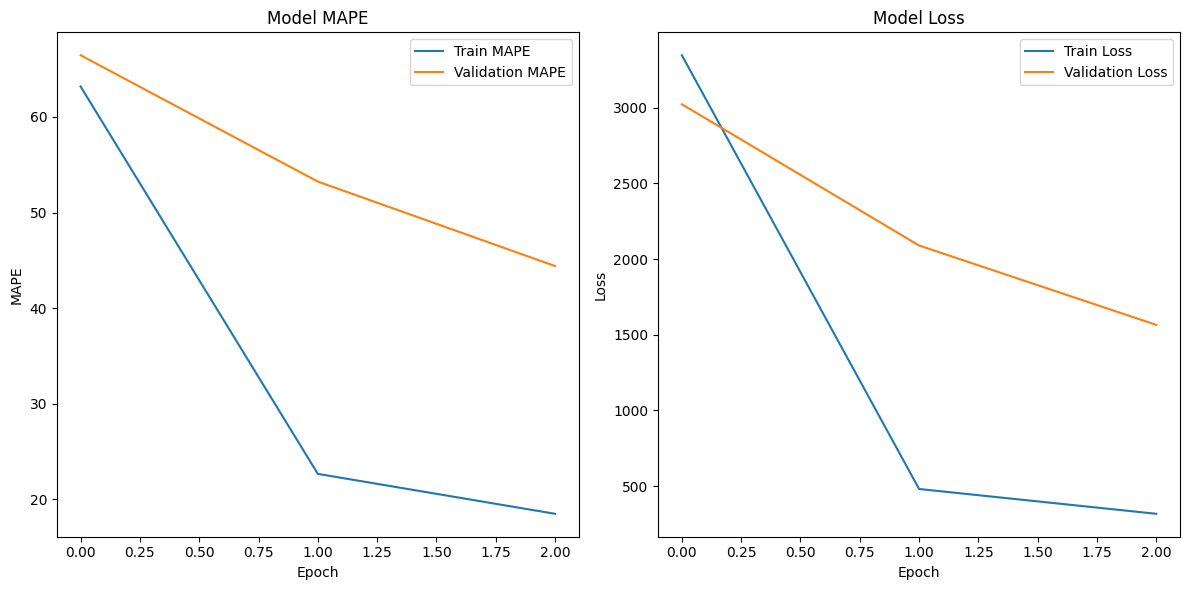

In [22]:
# Traccia la storia dell'addestramento
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Grafico MAPE (Errore Percentuale Medio Assoluto)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_percentage_error'], label='Train MAPE')
    plt.plot(history.history['val_mean_absolute_percentage_error'], label='Validation MAPE')
    plt.title('Model MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.legend(loc='upper right')

    # Grafico della perdita (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(output_dir + '/training_cnn_learning_curves.png')
    plt.show()

# Esegui la funzione per tracciare i grafici
plot_training_history(history)


## Save the Final Model 

In [23]:
# Save the final .keras model
model.save(output_dir + '/modello_cnn_finale.keras')

## Evaluating the Model on Test Dataset

In [24]:
# Funzione per ottenere i nomi dei file immagine nella directory specificata
def get_image_filenames(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')  # Definisce le estensioni valide per i file immagine
    filenames = [os.path.join(directory, img_name) for img_name in os.listdir(directory) 
                 if img_name.lower().endswith(valid_extensions)]  # Filtra i file per estensioni valide
    return filenames  # Restituisce la lista dei percorsi completi dei file immagine

# Funzione per caricare le etichette da un file Excel
def load_labels_from_excel_with_filenames(excel_file):
    df = pd.read_excel(excel_file)  # Carica il file Excel in un DataFrame Pandas
    filenames = df['Filename'].values  # Estrae i nomi dei file dalle colonne del DataFrame
    labels = df['RST'].values  # Estrae le etichette (RST) dalle colonne del DataFrame
    return df, dict(zip(filenames, labels)), filenames  # Restituisce il DataFrame, un dizionario file-etichetta, e l'elenco dei nomi file

# Funzione per caricare i dati di test: immagini e etichette
def load_test_data(dataset_dir):
    # Carica il DataFrame di test e il dizionario file-etichetta
    test_df, test_labels_dict, test_filenames_from_excel = load_labels_from_excel_with_filenames(os.path.join(dataset_dir, 'test.xlsx'))
    test_image_filenames = get_image_filenames(os.path.join(dataset_dir, 'test'))  # Ottiene i nomi dei file immagine
    
    # Filtra le immagini che non hanno corrispondenza nelle etichette
    true_labels_from_excel = []
    for fname in test_image_filenames:
        base_name = os.path.basename(fname)  # Estrae il nome del file
        if base_name in test_labels_dict:  # Verifica se il file ha un'etichetta corrispondente
            true_labels_from_excel.append(test_labels_dict[base_name])  # Aggiunge l'etichetta corrispondente
        else:
            print(f"Warning: '{base_name}' not found in the Excel file and will be skipped.")  # Avviso per file senza etichetta

    return test_df, test_image_filenames, test_labels_dict, test_filenames_from_excel, true_labels_from_excel  # Restituisce i dati di test

# Funzione per calcolare il numero di passi (batch) necessari per processare l'insieme di test
def calculate_test_steps(test_image_filenames, batch_size):
    return np.ceil(len(test_image_filenames) / batch_size).astype(int)  # Calcola e restituisce il numero di batch

# Funzione per eseguire le predizioni sul dataset di test
def predict_results(model, test_dataset, test_steps):
    start_time = time.time()  # Inizia il timer
    preds = model.predict(test_dataset, steps=test_steps)  # Esegue le predizioni sui dati di test
    test_duration = time.time() - start_time  # Calcola la durata del test
    return preds, test_duration  # Restituisce le predizioni e la durata del test

# Funzione per valutare il modello sul dataset di test
def evaluate_model(model, test_dataset, test_steps):
    result = model.evaluate(test_dataset, steps=test_steps)  # Valuta il modello e calcola le metriche
    metrics_result = dict(zip(model.metrics_names, result))  # Crea un dizionario con i nomi delle metriche e i rispettivi valori
    print('Metrics Results:', metrics_result)  # Stampa le metriche di valutazione
    return metrics_result  # Restituisce le metriche

# Funzione per aggiungere le etichette previste al DataFrame originale
def add_predicted_labels_to_df(test_df, test_labels_pred, test_filenames_from_excel, test_image_filenames):
    test_df['Predicted Label'] = [
        test_labels_pred[test_filenames_from_excel.tolist().index(os.path.basename(fname))]
        if os.path.basename(fname) in test_filenames_from_excel else None  # Aggiunge la predizione solo se il file ha una corrispondenza
        for fname in test_image_filenames
    ]
    return test_df  # Restituisce il DataFrame aggiornato con le predizioni

# Funzione per creare un DataFrame con i risultati del test
def create_test_results_df(test_duration, metrics_result):
    test_loss = metrics_result.get('loss')  # Ottiene la perdita dal dizionario delle metriche
    test_mape = metrics_result.get('compile_metrics')  # Ottiene il MAPE (da modificare se necessario)
    return pd.DataFrame({
        'Metric': ['Test Duration [s]', 'Test Loss', 'Test MAPE'],  # Crea un DataFrame con le metriche principali
        'Value': [test_duration, test_loss, test_mape]
    })

# Funzione per raggruppare per 'PLOT' e calcolare la media della 'Predicted Label' e MAPE
def group_by_plot_and_calculate_metrics(test_df):
    grouped_df = test_df.groupby('PLOT').agg({
        'RST': 'first',  # Assume che RST sia lo stesso all'interno di ogni PLOT
        'CROP': 'first',  # Assume che CROP sia lo stesso all'interno di ogni PLOT
        'Predicted Label': 'mean'  # Calcola la media delle predizioni per ogni PLOT
    }).reset_index()
    grouped_df['MAPE'] = abs((grouped_df['RST'] - grouped_df['Predicted Label']) / grouped_df['RST']) * 100  # Calcola il MAPE
    overall_mape = grouped_df['MAPE'].mean()  # Calcola il MAPE complessivo
    overall_mape_df = pd.DataFrame({
        'PLOT': ['Overall'],
        'RST': [None],
        'CROP': [None],
        'Predicted Label': [None],
        'MAPE': [overall_mape]
    }).dropna(axis=1, how='all')  # Crea una riga aggiuntiva per il MAPE complessivo
    grouped_df = pd.concat([grouped_df, overall_mape_df], ignore_index=True)  # Unisce i risultati
    return grouped_df  # Restituisce il DataFrame raggruppato

# Funzione per salvare i DataFrame in un file Excel
def save_to_excel(output_dir, test_results_df, test_df, grouped_df):
    with pd.ExcelWriter(os.path.join(output_dir, 'test_cnn.xlsx')) as writer:
        test_results_df.to_excel(writer, sheet_name='Test Results', index=False)  # Salva i risultati del test
        test_df.to_excel(writer, sheet_name='Tile Predictions', index=False)  # Salva il DataFrame delle predizioni
        grouped_df.to_excel(writer, sheet_name='Plot Predictions', index=False)  # Salva il DataFrame raggruppato

# Workflow principale che coordina tutte le operazioni
def main(dataset_dir, output_dir, model, test_dataset, batch_size):
    test_df, test_image_filenames, test_labels_dict, test_filenames_from_excel, true_labels_from_excel = load_test_data(dataset_dir)  # Carica i dati di test
    test_steps = calculate_test_steps(test_image_filenames, batch_size)  # Calcola il numero di passi di test
    preds, test_duration = predict_results(model, test_dataset, test_steps)  # Esegue le predizioni
    metrics_result = evaluate_model(model, test_dataset, test_steps)  # Valuta il modello
    test_labels_pred = preds.flatten()  # Appiattisce l'array delle predizioni
    test_df = add_predicted_labels_to_df(test_df, test_labels_pred, test_filenames_from_excel, test_image_filenames)  # Aggiunge le predizioni al DataFrame
    test_results_df = create_test_results_df(test_duration, metrics_result)  # Crea il DataFrame con i risultati del test
    grouped_df = group_by_plot_and_calculate_metrics(test_df)  # Raggruppa per PLOT e calcola le metriche
    save_to_excel(output_dir, test_results_df, test_df, grouped_df)  # Salva tutto in un file Excel

# Chiamata alla funzione principale con i parametri specificati
main(dataset_dir, output_dir, model, test_dataset, BATCH_SIZE)



10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 695ms/step - loss: 1676.6881 - mean_absolute_percentage_error: 45.0956
Metrics Results: {'loss': 1617.2923583984375, 'compile_metrics': 44.69553756713867}


1. Caricamento dei File Immagine e delle Etichette
- Funzione: load_test_data
- Processo:
    - Caricamento delle Immagini: La CPU legge i nomi dei file immagine dal disco e li carica in RAM come una lista di percorsi.
    - Caricamento delle Etichette: Viene caricato il file Excel contenente le etichette in un DataFrame Pandas (test_df).
    - Corrispondenza Immagini-Etichette: Le immagini che non hanno una corrispondenza nelle etichette vengono filtrate e ignorate. Le etichette corrispondenti vengono memorizzate in un dizionario (test_labels_dict) e in un array (true_labels_from_excel).
 
2. Calcolo dei Passi per il Test
- Funzione: calculate_test_steps
- Processo:
    - La CPU calcola il numero di batch necessari per processare tutte le immagini di test, basandosi sul numero totale di immagini e sulla dimensione del batch.
    - Questo valore (test_steps) viene memorizzato in RAM per l'utilizzo successivo.
 
3. Predizione dei Risultati sul Dataset di Test
- Funzione: predict_results
- Processo:
    - Batch Processing: Il modello processa le immagini in batch (ad es., 32 immagini per batch).
    - Parallelismo: Ogni batch viene processato in parallelo sulla GPU/TPU, con tutte le immagini nel batch elaborate contemporaneamente.
    - Output: Per ogni batch, il modello genera un array di predizioni (etichette previste) per ciascuna immagine. Questo array viene accumulato fino a coprire tutte le immagini di test.
    - Memoria: Solo un batch è caricato in RAM alla volta. Una volta processato, le predizioni vengono salvate in un array (test_labels_pred), e la memoria è liberata per il batch successivo.
    - Risultato Finale: Alla fine del processo, tutte le predizioni per le immagini di test sono state accumulate in test_labels_pred.
 
4. Valutazione del Modello sul Dataset di Test
- Funzione: evaluate_model
- Processo:
    - Batch Processing: Come nella predizione, le immagini sono processate in batch.
    - Parallelismo: La GPU/TPU elabora le immagini in parallelo per ciascun batch.
    - Calcolo delle Metriche: Oltre a fare le predizioni, il modello calcola la perdita (loss) e il MAPE per ogni batch.
    - Aggregazione delle Metriche:
        - Dopo aver calcolato le metriche per un batch, queste vengono combinate con le metriche calcolate sui batch precedenti.
        - Alla fine della valutazione su tutti i batch, le metriche finali, come la media della perdita e del MAPE, sono calcolate per l'intero dataset di test.
    - Output: Queste metriche finali vengono memorizzate in un dizionario (metrics_result), che rappresenta la performance complessiva del modello su tutto il dataset di test.
 
5. Aggiunta delle Predizioni al DataFrame
- Funzione: add_predicted_labels_to_df
- Processo:
    - Le predizioni ottenute dal modello (test_labels_pred) vengono aggiunte come nuova colonna (Predicted Label) al DataFrame originale test_df, associando ciascuna predizione all'immagine corrispondente.
 
6. Creazione del DataFrame dei Risultati di Test
- Funzione: create_test_results_df
- Processo:
    - Viene creato un nuovo DataFrame (test_results_df) che contiene:
        - La durata totale del test (test_duration).
        - La perdita finale (test_loss) e il MAPE calcolato (test_mape) su tutto il dataset di test.
    - Questo DataFrame è utilizzato per riportare i risultati complessivi della valutazione.

7. Raggruppamento per "PLOT" e Calcolo delle Metriche
- Funzione: group_by_plot_and_calculate_metrics
- Processo:
    - I dati di test_df vengono raggruppati per "PLOT", e per ogni gruppo vengono calcolate le medie delle predizioni e il MAPE.
    - Un ulteriore DataFrame (grouped_df) viene creato per rappresentare queste metriche raggruppate, inclusa una riga aggiuntiva che mostra il MAPE complessivo per tutto il dataset.

8. alvataggio dei Risultati in un File Excel
- Funzione: save_to_excel
- Processo:
    - Tutti i DataFrame generati (test_results_df, test_df, grouped_df) vengono salvati in un file Excel sul disco.
    - La memoria RAM viene liberata una volta che i dati sono scritti su disco, completando così il workflow.

## Final message

In [25]:
# Create a completion marker file
with open(output_dir + '/FATTO!.txt', 'w') as file:
    file.write('Evviva!')

print('Il processo si è concluso')


Il processo si è concluso


# **Feature extraction**

In [27]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input

###########################################

# Parametri principali per l'estrazione delle feature
IMG_SIZE = 380  # Dimensione delle immagini dopo il ridimensionamento
BATCH_SIZE = 32  # Numero di immagini processate in parallelo per batch
dataset_dir = 'Prova'  # Directory principale contenente i dataset
output_dir = 'Output_' + dataset_dir  # Directory di output per salvare i risultati
layer_name = 'dense_1'  # Nome del layer dal quale estrarre le feature

# Carica il modello addestrato
model = tf.keras.models.load_model(os.path.join(output_dir, 'modello_cnn_finale.keras'))
# Crea un modello che termina al layer specificato per l'estrazione delle feature
feature_extractor_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

###########################################

# Funzione per caricare le etichette da file Excel
def load_labels_from_excel(excel_file):
    df = pd.read_excel(excel_file)  # Carica il file Excel in un DataFrame pandas
    # Restituisce tre dizionari: uno per le etichette, uno per i plot, e uno per i tipi di coltura (crop)
    return dict(zip(df['Filename'], df['RST'])), dict(zip(df['Filename'], df['PLOT'])), dict(zip(df['Filename'], df['CROP']))

# Funzione per ottenere i percorsi delle immagini e le loro etichette
def load_image_paths_and_labels(directory, labels_dict, plots_dict, crops_dict):
    image_paths, image_labels, image_plots, image_crops = [], [], [], []
    for root, _, files in os.walk(directory):  # Itera attraverso tutte le directory e sottodirectory
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Controlla solo i file immagine
                # Aggiunge i percorsi delle immagini e le etichette corrispondenti alle liste
                image_paths.append(os.path.join(root, file))
                image_labels.append(labels_dict.get(file, -1))  # -1 se l'etichetta non è trovata
                image_plots.append(plots_dict.get(file, ''))  # Stringa vuota se non trovata
                image_crops.append(crops_dict.get(file, ''))  # Stringa vuota se non trovata
    return image_paths, image_labels, image_plots, image_crops

# Funzione per caricare e preprocessare un'immagine
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)  # Legge l'immagine dal disco
    img = tf.image.decode_image(img, channels=3)  # Decodifica l'immagine in RGB
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Ridimensiona l'immagine
    img = preprocess_input(img)  # Applica il preprocessing specifico per EfficientNet
    return img

# Funzione per estrarre le feature in batch
def extract_features_in_batches(image_paths, batch_size):
    num_images = len(image_paths)  # Numero totale di immagini
    num_batches = (num_images + batch_size - 1) // batch_size  # Numero totale di batch
    features = []

    start_time = time.time()  # Tempo di inizio dell'estrazione
    
    for i in tqdm(range(num_batches), desc="Extracting features"):  # Loop sui batch
        batch_paths = image_paths[i*batch_size:(i+1)*batch_size]  # Ottiene i percorsi per il batch corrente
        batch_images = [load_and_preprocess_image(path) for path in batch_paths]  # Carica e preprocessa le immagini del batch
        batch_images = np.array(batch_images)  # Converte la lista in array numpy
        batch_features = feature_extractor_model.predict(batch_images)  # Estrae le feature usando il modello
        for feature in batch_features:
            features.append(feature.flatten())  # Appiattisce e aggiunge le feature alla lista
    
    end_time = time.time()  # Tempo di fine dell'estrazione

    avg_time_per_image = (end_time - start_time) / num_images  # Calcola il tempo medio per immagine
    print(f'Feature extraction completed in {end_time - start_time:.2f} seconds, averaging {avg_time_per_image:.4f} seconds per image.')
    return np.array(features), avg_time_per_image  # Restituisce le feature estratte e il tempo medio per immagine

# Funzione per creare un DataFrame con le feature estratte e le informazioni correlate
def create_feature_df(image_paths, features, labels, plots, crops):
    feature_data = []
    for img_path, feature_vector, label, plot, crop in zip(image_paths, features, labels, plots, crops):
        filename = os.path.basename(img_path)  # Ottiene il nome del file dall'intero percorso
        feature_row = [filename, label, plot, crop] + list(feature_vector)  # Crea una riga di dati con tutte le informazioni
        feature_data.append(feature_row)
    
    feature_columns = ['Filename', 'RST', 'PLOT', 'CROP'] + [f'Feature_{i+1}' for i in range(features.shape[1])]  # Nomi delle colonne
    return pd.DataFrame(feature_data, columns=feature_columns)  # Crea e restituisce un DataFrame

################################################

# Caricamento delle etichette e dei percorsi delle immagini per train, validation, e test
train_labels_dict, train_plots_dict, train_crops_dict = load_labels_from_excel(os.path.join(dataset_dir, 'train.xlsx'))
val_labels_dict, val_plots_dict, val_crops_dict = load_labels_from_excel(os.path.join(dataset_dir, 'validation.xlsx'))
test_labels_dict, test_plots_dict, test_crops_dict = load_labels_from_excel(os.path.join(dataset_dir, 'test.xlsx'))

train_image_paths, train_image_labels, train_image_plots, train_image_crops = load_image_paths_and_labels(os.path.join(dataset_dir, 'train'), train_labels_dict, train_plots_dict, train_crops_dict)
val_image_paths, val_image_labels, val_image_plots, val_image_crops = load_image_paths_and_labels(os.path.join(dataset_dir, 'validation'), val_labels_dict, val_plots_dict, val_crops_dict)
test_image_paths, test_image_labels, test_image_plots, test_image_crops = load_image_paths_and_labels(os.path.join(dataset_dir, 'test'), test_labels_dict, test_plots_dict, test_crops_dict)

# Estrazione delle feature per train, validation, e test
train_features, train_avg_time_per_image = extract_features_in_batches(train_image_paths, batch_size=BATCH_SIZE)
val_features, val_avg_time_per_image = extract_features_in_batches(val_image_paths, batch_size=BATCH_SIZE)
test_features, test_avg_time_per_image = extract_features_in_batches(test_image_paths, batch_size=BATCH_SIZE)

##################################################

# Salvataggio delle feature e delle etichette in un file compresso .npz
output_filename = f'extracted_features_{layer_name}.npz'
np.savez_compressed(os.path.join(output_dir, output_filename),
                    train_features=train_features, train_labels=train_image_labels, train_plots=train_image_plots, train_crops=train_image_crops,
                    val_features=val_features, val_labels=val_image_labels, val_plots=val_image_plots, val_crops=val_image_crops,
                    test_features=test_features, test_labels=test_image_labels, test_plots=test_image_plots, test_crops=test_image_crops)

#################################################

# Creazione dei DataFrame delle feature per train, validation, e test
train_feature_df = create_feature_df(train_image_paths, train_features, train_image_labels, train_image_plots, train_image_crops)
val_feature_df = create_feature_df(val_image_paths, val_features, val_image_labels, val_image_plots, val_image_crops)
test_feature_df = create_feature_df(test_image_paths, test_features, test_image_labels, test_image_plots, test_image_crops)

# Salvataggio del tempo di estrazione delle feature su un file Excel
time_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Time per Image (s)': [train_avg_time_per_image, val_avg_time_per_image, test_avg_time_per_image]
})

# Creazione di un DataFrame con le informazioni sul layer usato per l'estrazione delle feature
layer_info_df = pd.DataFrame({
    'Parameter': ['Feature Extraction Layer'],
    'Value': [layer_name]
})

##############################################

# Salvataggio dei risultati su un file Excel con più fogli
with pd.ExcelWriter(os.path.join(output_dir, f'extracted_features_{layer_name}.xlsx')) as writer:
    time_df.to_excel(writer, sheet_name='Extraction Times', index=False)
    train_feature_df.to_excel(writer, sheet_name='Train Features', index=False)
    val_feature_df.to_excel(writer, sheet_name='Validation Features', index=False)
    test_feature_df.to_excel(writer, sheet_name='Test Features', index=False)
    layer_info_df.to_excel(writer, sheet_name='Layer Information', index=False)

#################################################

print(f"Feature extraction and saving completed. Features saved as {output_filename}.")

Extracting features:   0%|                                                                      | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Extracting features:   3%|█▉                                                            | 1/33 [00:05<02:43,  5.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:   6%|███▊                                                          | 2/33 [00:06<01:31,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:   9%|█████▋                                                        | 3/33 [00:08<01:08,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  12%|███████▌                                                      | 4/33 [00:09<00:56,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  15%|█████████▍                                                    | 5/33 [00:10<00:49,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  18%|███████████▎                                                  | 6/33 [00:12<00:45,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  21%|█████████████▏                                                | 7/33 [00:13<00:41,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  24%|███████████████                                               | 8/33 [00:15<00:39,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  27%|████████████████▉                                             | 9/33 [00:16<00:36,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  30%|██████████████████▍                                          | 10/33 [00:18<00:35,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  33%|████████████████████▎                                        | 11/33 [00:19<00:33,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  36%|██████████████████████▏                                      | 12/33 [00:21<00:31,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  39%|████████████████████████                                     | 13/33 [00:22<00:29,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  42%|█████████████████████████▉                                   | 14/33 [00:24<00:28,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  45%|███████████████████████████▋                                 | 15/33 [00:25<00:26,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  48%|█████████████████████████████▌                               | 16/33 [00:27<00:25,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  52%|███████████████████████████████▍                             | 17/33 [00:28<00:23,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  55%|█████████████████████████████████▎                           | 18/33 [00:30<00:22,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  58%|███████████████████████████████████                          | 19/33 [00:31<00:20,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  61%|████████████████████████████████████▉                        | 20/33 [00:33<00:19,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  64%|██████████████████████████████████████▊                      | 21/33 [00:34<00:17,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  67%|████████████████████████████████████████▋                    | 22/33 [00:36<00:16,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  70%|██████████████████████████████████████████▌                  | 23/33 [00:37<00:14,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  73%|████████████████████████████████████████████▎                | 24/33 [00:39<00:13,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  76%|██████████████████████████████████████████████▏              | 25/33 [00:40<00:11,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  79%|████████████████████████████████████████████████             | 26/33 [00:42<00:10,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  82%|█████████████████████████████████████████████████▉           | 27/33 [00:43<00:08,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  85%|███████████████████████████████████████████████████▊         | 28/33 [00:44<00:07,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  88%|█████████████████████████████████████████████████████▌       | 29/33 [00:46<00:05,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  91%|███████████████████████████████████████████████████████▍     | 30/33 [00:47<00:04,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  94%|█████████████████████████████████████████████████████████▎   | 31/33 [00:49<00:02,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  97%|███████████████████████████████████████████████████████████▏ | 32/33 [00:50<00:01,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Extracting features: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:55<00:00,  1.67s/it]


Feature extraction completed in 55.27 seconds, averaging 0.0526 seconds per image.


Extracting features:   0%|                                                                      | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  10%|██████▏                                                       | 1/10 [00:01<00:13,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  20%|████████████▍                                                 | 2/10 [00:03<00:12,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  30%|██████████████████▌                                           | 3/10 [00:04<00:10,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  40%|████████████████████████▊                                     | 4/10 [00:06<00:09,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  50%|███████████████████████████████                               | 5/10 [00:07<00:07,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  60%|█████████████████████████████████████▏                        | 6/10 [00:09<00:05,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  70%|███████████████████████████████████████████▍                  | 7/10 [00:10<00:04,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  80%|█████████████████████████████████████████████████▌            | 8/10 [00:11<00:02,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  90%|███████████████████████████████████████████████████████▊      | 9/10 [00:13<00:01,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


Extracting features: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Feature extraction completed in 14.06 seconds, averaging 0.0467 seconds per image.


Extracting features:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  20%|████████████▌                                                  | 1/5 [00:01<00:05,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  40%|█████████████████████████▏                                     | 2/5 [00:02<00:04,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  60%|█████████████████████████████████████▊                         | 3/5 [00:04<00:02,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features:  80%|██████████████████████████████████████████████████▍            | 4/5 [00:05<00:01,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Extracting features: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]

Feature extraction completed in 7.06 seconds, averaging 0.0458 seconds per image.


Feature extraction and saving completed. Features saved as extracted_features_dense_1.npz.


# **Random Forest**

In [28]:
import os
import time
import joblib
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

######################################

# Parametri principali
dataset_dir = 'Prova'  # Directory del dataset
output_dir = 'Output_' + dataset_dir  # Directory di output per salvare i risultati
layer_name = 'dense_1'  # Nome del layer per l'estrazione delle feature

# Parametri specifici per il modello Random Forest
n_estimators = 500  # Numero di alberi nella foresta
random_state = None  # Controlla la randomizzazione del modello
n_jobs = 2  # Numero di thread per il parallelismo (1 significa nessun parallelismo)

#####################################
    
# Caricamento delle feature estratte
data = np.load(os.path.join(output_dir, f'extracted_features_{layer_name}.npz'))

# Recupero delle feature e delle etichette dai dati caricati
train_features = data['train_features']
train_labels = data['train_labels']
train_plots = data['train_plots']
train_crops = data['train_crops']

val_features = data['val_features']
val_labels = data['val_labels']
val_plots = data['val_plots']
val_crops = data['val_crops']

test_features = data['test_features']
test_labels = data['test_labels']
test_plots = data['test_plots']
test_crops = data['test_crops']

#####################################

# Funzione per raggruppare le feature per plot
def group_features_by_plot(features, plots, labels, crops):
    # Inizializza i dizionari per raggruppare le feature, le etichette e i tipi di coltura per plot
    grouped_features = defaultdict(list)
    grouped_labels = {}
    grouped_crops = {}
    
    # Raggruppa le feature, le etichette e i tipi di coltura per plot
    for feature, plot, label, crop in zip(features, plots, labels, crops):
        grouped_features[plot].append(feature)
        if plot not in grouped_labels:
            grouped_labels[plot] = label
        if plot not in grouped_crops:
            grouped_crops[plot] = crop
    
    # Calcola la media delle feature per ciascun plot
    mean_features = {plot: np.mean(group, axis=0) for plot, group in grouped_features.items()}
    mean_labels = {plot: grouped_labels[plot] for plot in grouped_features.keys()}
    mean_crops = {plot: grouped_crops[plot] for plot in grouped_features.keys()}
    
    return mean_features, mean_labels, mean_crops

# Raggruppamento delle feature per plot per i set di train, validation e test
train_mean_features_dict, train_mean_labels_dict, train_mean_crops_dict = group_features_by_plot(train_features, train_plots, train_labels, train_crops)
val_mean_features_dict, val_mean_labels_dict, val_mean_crops_dict = group_features_by_plot(val_features, val_plots, val_labels, val_crops)
test_mean_features_dict, test_mean_labels_dict, test_mean_crops_dict = group_features_by_plot(test_features, test_plots, test_labels, test_crops)

# Conversione dei dizionari in array
train_mean_features = np.array(list(train_mean_features_dict.values()))
train_mean_labels = np.array(list(train_mean_labels_dict.values()))
val_mean_features = np.array(list(val_mean_features_dict.values()))
val_mean_labels = np.array(list(val_mean_labels_dict.values()))
test_mean_features = np.array(list(test_mean_features_dict.values()))
test_mean_labels = np.array(list(test_mean_labels_dict.values()))

#################################################

# Addestramento del modello Random Forest
print('Starting Random Forest training...')
start_time = time.time()  # Inizia il timer per misurare il tempo di addestramento

# Creazione del modello con solo n_estimators, random_state e n_jobs definiti
rf_regressor = RandomForestRegressor(
    n_estimators=n_estimators,
    random_state=random_state,
    n_jobs=n_jobs  # Definisce il numero di processi paralleli (1 significa nessun parallelismo)
)

# Addestra il modello sui dati di train
rf_regressor.fit(train_mean_features, train_mean_labels)
end_time = time.time()  # Fine del timer

# Calcola il tempo totale di addestramento e il tempo medio per immagine
total_training_time = end_time - start_time
avg_training_time_per_image = total_training_time / len(train_mean_features)
print(f'Finished Random Forest training. Training took {total_training_time:.2f} seconds, averaging {avg_training_time_per_image:.4f} seconds per image.')

############################################

# Predizione sui set di validation e test
val_preds = rf_regressor.predict(val_mean_features)  # Predizione sui dati di validation
test_preds = rf_regressor.predict(test_mean_features)  # Predizione sui dati di test

# Calcolo del MAPE (Mean Absolute Percentage Error) per validation e test set
val_mape = mean_absolute_percentage_error(val_mean_labels, val_preds)
test_mape = mean_absolute_percentage_error(test_mean_labels, test_preds)

print(f'Validation MAPE: {val_mape}')
print(f'Test MAPE: {test_mape}')

#############################################

# Salvataggio del modello Random Forest addestrato
joblib.dump(rf_regressor, os.path.join(output_dir, f'modello_RF_{layer_name}.pkl'))

##############################################
# Preparazione del DataFrame per le predizioni sui set di validation e test
val_pred_df = pd.DataFrame({
    'Plot': list(val_mean_features_dict.keys()),
    'CROP': list(val_mean_crops_dict.values()),
    'True Label': list(val_mean_labels_dict.values()),
    'Predicted Label': val_preds
})

test_pred_df = pd.DataFrame({
    'Plot': list(test_mean_features_dict.keys()),
    'CROP': list(test_mean_crops_dict.values()),
    'True Label': list(test_mean_labels_dict.values()),
    'Predicted Label': test_preds
})

overall_mape_val = pd.DataFrame({
        'Plot': ['Overall MAPE'],
        'CROP': [val_mape],
        'True Label': [''],
        'Predicted Label': ['']
    })
val_pred_df = pd.concat([val_pred_df, overall_mape_val], ignore_index=True)

overall_mape_test = pd.DataFrame({
        'Plot': ['Overall MAPE'],
        'CROP': [test_mape],
        'True Label': [''],
        'Predicted Label': ['']
    })
test_pred_df = pd.concat([test_pred_df, overall_mape_test], ignore_index=True)

# Aggiunta del MAPE complessivo ai DataFrame di predizione
#val_pred_df['Validation MAPE'] = val_mape
#test_pred_df['Test MAPE'] = test_mape

# Calcolo del MAPE complessivo per il foglio di calcolo
#overall_mape = mean_absolute_percentage_error(test_pred_df['True Label'], test_pred_df['Predicted Label'])

# Salvataggio dei risultati su Excel
time_df = pd.DataFrame({
    'Set': ['Random Forest Training'],
    'Time per Image (s)': [avg_training_time_per_image]
})

# Aggiunta di tutti i parametri del modello al foglio di struttura
rf_structure_df = pd.DataFrame({
    'Parameter': ['n_estimators', 'random_state', 'n_jobs', 'feature_extraction_layer'],
    'Value': [n_estimators, random_state, n_jobs, layer_name]
})

# Salva tutti i risultati e le informazioni su un file Excel
with pd.ExcelWriter(os.path.join(output_dir, f'test_RF_{layer_name}.xlsx')) as writer:
    val_pred_df.to_excel(writer, sheet_name='Validation Predictions', index=False)
    test_pred_df.to_excel(writer, sheet_name='Test Predictions', index=False)
    time_df.to_excel(writer, sheet_name='Time per Image', index=False)
    rf_structure_df.to_excel(writer, sheet_name='Random Forest Structure', index=False)
    print('Results saved to Excel.')

Starting Random Forest training...
Finished Random Forest training. Training took 0.45 seconds, averaging 0.0322 seconds per image.
Validation MAPE: 0.18193972625352878
Test MAPE: 0.23448309404486029
Results saved to Excel.
